In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from collections import defaultdict

import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

import itertools

import random

from skimage import measure
import dill
import csv


In [2]:
def read_image(path):
    return plt.imread(path)

(480, 640)


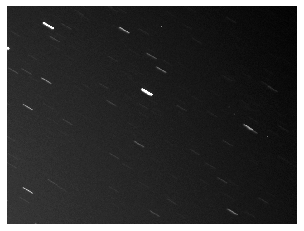

In [3]:
example_image=read_image('geoSatellites/train/1/1.png')
print(example_image.shape)
plt.imshow(example_image, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
def read_annotation_file(path):
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict
random.seed(0)

def random_different_coordinates(coords, size_x, size_y, pad,img_arr,avg):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        #print(size_x,size_y)
        #'''
        img_arr = img_arr[pad  : size_y - pad ,pad : size_x - pad]
        #print(img_arr.shape)
        srt_arr = np.sort(img_arr, axis=None)
        srt_arr1 = np.concatenate((srt_arr[:1000],srt_arr[-1000:]),axis=0)
        #srt_arr2 = np.concatenate((srt_arr1,srt_arr[99000:100000]),axis=0)
        #srt_arr3 = np.concatenate((srt_arr2,srt_arr[199000:200000]),axis=0)
        itemsmean = np.where(srt_arr==avg)
        sizemean = itemsmean[0].shape[0]
        totalsize=1000
        #sizemean2 = itemsmean[1].shape[0]
        if  sizemean != 0:
            #print("existeq")
            #sizemean = random.randint(0,sizemean-1)
            if sizemean>1000:
                #print("bigger of 2000")
                srt_arr= np.concatenate((srt_arr1,srt_arr[itemsmean[0][:1000]]),axis=0)
            else:
                print("smaller")
                rest = (1000 - sizemean)/2
                if (1000-sizemean) % 2 == 0:
                        srt_arr= np.concatenate((srt_arr1,srt_arr[itemsmean[0][0]-rest:itemsmean[0][0]+sizemean+rest]),axis=0)
                else:
                    srt_arr= np.concatenate((srt_arr1,srt_arr[itemsmean[0][0]-rest:itemsmean[0][0]+sizemean+rest+1]),axis=0)
                #srt_arr_tmp= np.concatenate((srt_arr2,srt_arr[itemsmean[0][0]:itemsmean[0][0]+sizemean]),axis=0)
                #rest = (2000 - sizemean)
            #sizemean2 = random.randint(0,sizemean2-1)
            #add avg on srt_arr
        else:
            #print("noneq")
            biggermean = np.where(srt_arr>avg)
            #print(biggermean[0])
            if biggermean[0].shape[0] == 0:
                indexbig = 302236
            else:
                indexbig = biggermean[0][0]
            #print([biggermean[0]])
            smaller_size = 500
            bigger_size = 500
            if indexbig < 500:
                #print('sm')
                smaller_size = indexbig
            elif indexbig>302236:
                #print('big')
                bigger_size = 302736-indexbig
            totalsize = smaller_size + bigger_size
            srt_arr= np.concatenate((srt_arr1,srt_arr[indexbig-smaller_size:indexbig+bigger_size]),axis=0)    
            #
        rd = random.randint(0,1999+totalsize)
        #c2 = random.randint(0,3000)
        itemindex = np.where(img_arr==srt_arr[rd])
        lim1 = itemindex[0].shape[0]-1
        lim2 = itemindex[1].shape[0]-1
        #print(lim1)
        #print(itemindex)
        c1 = itemindex[0][random.randint(0,lim1)]+pad
        c2 = itemindex[1][random.randint(0,lim2)]+pad
        #'''
        #c1 = random.randint(pad,size_y - (pad+1))
        #c2 = random.randint(pad,size_x - (pad+1))
        #print(c1,c2)
        for c in coords:
            if c1 == c[1] and c2 == c[0]:
                good = False
                break
    return (c2,c1)

def extract_neighborhood(x, y, arr, radius):
    """ Returns a 1-d array of the values within a radius of the x,y coordinates given """
    return arr[(x - radius) : (x + radius + 1), (y - radius) : (y + radius + 1)].ravel()

def check_coordinate_validity(x, y, size_x, size_y, pad):
    """ Check if a coordinate is not too close to the image edge """
    return x >= pad and y >= pad and x + pad < size_x and y + pad < size_y

def generate_labeled_data(image_path, annotation, nb_false, radius, avg):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            #print(im_array[obj[1],obj[0]])
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
    # False samples
    for i in range(nb_false):
        #print(i)
        #im_array_temp = np.copy(im_array)
        c = random_different_coordinates(annotation,im_array.shape[1],im_array.shape[0],radius,im_array,avg)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    u = np.array(labels)
    #print(features)
    #print(labels)
    v = np.stack(features,axis=1)
    return u,v

def generate_mean_data(image_path, annotation, mylist):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        mylist.append(im_array[obj[1],obj[0]])
    return mylist

train_annotation=read_annotation_file('geoSatellites/train_anno.json')

#d = generate_labeled_data(f"{'geoSatellites/train/'}{1207}/{2}.png",
                                    #train_annotation[1207][2],
                                    #10,
                                    #2)

In [5]:
'''img_arr = read_image(f"{'geoSatellites/train/'}{1207}/{2}.png")
for obj in train_annotation[1207][2]:
        for x in obj:
            print(x)
        obj = [int(x + .5) for x in obj]                  
        print(img_arr[obj[1],obj[0]])
srt_arr = np.flip(np.sort(img_arr, axis=None))
itemindex = np.where(srt_arr==0.3372549)
print(itemindex)'''

'img_arr = read_image(f"{\'geoSatellites/train/\'}{1207}/{2}.png")\nfor obj in train_annotation[1207][2]:\n        for x in obj:\n            print(x)\n        obj = [int(x + .5) for x in obj]                  \n        print(img_arr[obj[1],obj[0]])\nsrt_arr = np.flip(np.sort(img_arr, axis=None))\nitemindex = np.where(srt_arr==0.3372549)\nprint(itemindex)'

In [14]:
def generate_labeled_set(annotation_array, path, sequence_id_list, radius, nb_false,avg):
    # Generate labeled data for a list of sequences in a given path
    print(avg)
    labels,features = [],[]
    for seq_id in sequence_id_list:
        print(seq_id)
        for frame_id in range(1,6):
            d = generate_labeled_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius,avg)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

from statistics import mean
def generate_mean_set(annotation_array, path, sequence_id_list):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    truelist = []
    for seq_id in sequence_id_list:
        print(seq_id)
        for frame_id in range(1,6):
            truelist = generate_mean_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    truelist)
    #print(truelist)
    return float(sum(truelist) / len(truelist))

In [23]:
radius=2
avg = generate_mean_set(train_annotation,'geoSatellites/train/',range(1,501))
train_labels, train_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(1,501), radius, 3,avg)
print(train_labels.shape)
print(train_labels)
print(train_features.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [24]:
def random_different_testcoordinates(coords, size_x, size_y, pad,img_arr):
    """ Returns a random set of coordinates that is different from the provided coordinates, 
    within the specified bounds.
    The pad parameter avoids coordinates near the bounds."""
    good = False
    while not good:
        good = True
        #print(size_x,size_y)
        '''
        img_arr = img_arr[pad  : size_y - pad ,pad : size_x - pad]
        #print(img_arr.shape)
        srt_arr = np.flip(np.sort(img_arr, axis=None))
        rd = random.randint(0,10000)
        #c2 = random.randint(0,3000)
        itemindex = np.where(img_arr==srt_arr[rd])
        lim1 = itemindex[0].shape[0]-1
        lim2 = itemindex[1].shape[0]-1
        #print(lim1)
        #print(itemindex)
        c1 = itemindex[0][random.randint(0,lim1)]+pad
        c2 = itemindex[1][random.randint(0,lim2)]+pad
        '''
        c1 = random.randint(pad,size_y - (pad+1))
        c2 = random.randint(pad,size_x - (pad+1))
        #print(c1,c2)
        for c in coords:
            if c1 == c[1] and c2 == c[0]:
                good = False
                break
    return (c2,c1)

def generate_labeledtest_data(image_path, annotation, nb_false, radius):
    """ For one frame and one annotation array, returns a list of labels 
    (1 for true object and 0 for false) and the corresponding features as an array.
    nb_false controls the number of false samples
    radius defines the size of the sliding window (e.g. radius of 1 gives a 3x3 window)"""
    features,labels = [],[]
    im_array = read_image(image_path)
    # True samples
    for obj in annotation:
        obj = [int(x + .5) for x in obj] #Project the floating coordinate values onto integer pixel coordinates.
        # For some reason the order of coordinates is inverted in the annotation files
        if check_coordinate_validity(obj[1],obj[0],im_array.shape[0],im_array.shape[1],radius):
            #print(im_array[obj[1],obj[0]])
            features.append(extract_neighborhood(obj[1],obj[0],im_array,radius))
            labels.append(1)
    # False samples
    for i in range(nb_false):
        #print(i)
        #im_array_temp = np.copy(im_array)
        c = random_different_testcoordinates(annotation,im_array.shape[1],im_array.shape[0],radius,im_array)
        features.append(extract_neighborhood(c[1],c[0],im_array,radius))
        labels.append(0)
    u = np.array(labels)
    #print(features)
    #print(labels)
    v = np.stack(features,axis=1)
    return u,v

def generate_labeledtest_set(annotation_array, path, sequence_id_list, radius, nb_false):
    # Generate labeled data for a list of sequences in a given path
    labels,features = [],[]
    for seq_id in sequence_id_list:
        print(seq_id)
        for frame_id in range(1,6):
            d = generate_labeledtest_data(f"{path}{seq_id}/{frame_id}.png",
                                    annotation_array[seq_id][frame_id],
                                    nb_false,
                                    radius)
            labels.append(d[0])
            features.append(d[1])
    return np.concatenate(labels,axis=0), np.transpose(np.concatenate(features,axis=1))

from sklearn.svm import SVC
import pandas as pd
svc = SVC(C=100,gamma=1).fit(train_features,train_labels)
test_labels, test_features = generate_labeledtest_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500)
svc_labels = svc.predict(test_features)
with open('geo_resultsnotrandintell.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ['SVC rbf', 'RADIUS = '+str(radius),'NEGATIVE SAMPLING 3 INTEL NEGATIVES INTEL TOP,BOTTOM AND AVG'])
report = classification_report(svc_labels,test_labels,output_dict=True)
print(report)
df = pd.DataFrame(report).transpose()
df.to_csv('geo_resultsnotrandintell.csv',mode='a')
cf = confusion_matrix(svc_labels,test_labels)
print(cf)
df = pd.DataFrame(cf)
df.to_csv('geo_resultsnotrandintell.csv',mode='a')
print("Kappa =",cohen_kappa_score(svc_labels,test_labels))
with open('geo_resultsnotrandintell.csv', 'a', newline='') as csvfile:
    resultwriter = csv.writer(csvfile, delimiter=' ')
    resultwriter.writerow( ["Kappa = ",cohen_kappa_score(svc_labels,test_labels)])

501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
{'0': {'precision': 0.9982775510204082, 'recall': 0.9984324099248046, 'f1-score': 0.9983549744674076, 'support': 122481}, '1': {'precision': 0.548235294117647, 'recall': 0.5247747747747747, 'f1-score': 0.5362485615650172, 'support': 444}, 'accuracy': 0.9967215781980883, 'macro avg': {'precision': 0.7732564225690276, 'recall': 0.7616035923497897, 'f1-score': 0.7673017680162124, 'support': 122925}, 'weighted avg': {'precision': 0.9966520170601492, 'recall': 0.9967215781980883, 'f1-score': 0.9966858652762044, 'support': 122925}}
[[122289    192]
 [   211    233]]
Kappa = 0.5346043252147776


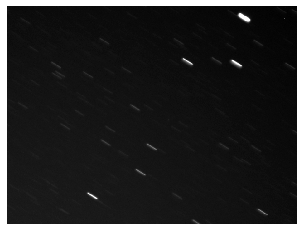

In [9]:
sequence_id, frame_id = 1202, 1
target_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
plt.imshow(target_image, cmap='gray')
plt.axis('off')
plt.show()

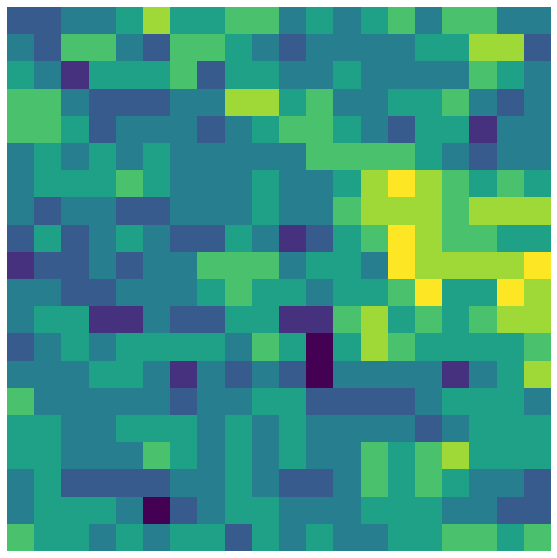

[[356.5250244140625, 250.01513671875]]


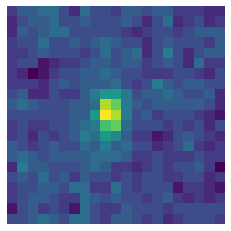

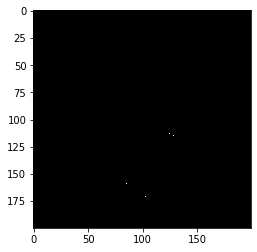

In [10]:
def classify_image(im, model, radius):
    n_features=(2*radius+1)**2 #Total number of pixels in the neighborhood
    feat_array=np.zeros((im.shape[0],im.shape[1],n_features))
    for x in range(radius+1,im.shape[0]-(radius+1)):
        for y in range(radius+1,im.shape[1]-(radius+1)):
            feat_array[x,y,:]=extract_neighborhood(x,y,im,radius)
    all_pixels=feat_array.reshape(im.shape[0]*im.shape[1],n_features)
    pred_pixels=model.predict(all_pixels).astype(np.bool_)
    pred_image=pred_pixels.reshape(im.shape[0],im.shape[1])
    return pred_image

pred_image=classify_image(target_image, svc, radius)
plt.figure(figsize=(15,10))
plt.imshow(target_image[350:370,240:260], interpolation='None')
plt.axis('off')
plt.show()
print(train_annotation[sequence_id][frame_id])
true_x=int(train_annotation[sequence_id][frame_id][0][1]+.5)
true_y=int(train_annotation[sequence_id][frame_id][0][0]+.5)
plt.imshow(extract_neighborhood(true_x, true_y, target_image, 10).reshape((21,21)))
plt.axis('off')
plt.show()
plt.imshow(pred_image[200:400,200:400], cmap='gray')
plt.show()
#origin="upper",interpolation="nearest"

In [11]:
def extract_centroids(pred, bg):
    conn_comp=measure.label(pred, background=bg)
    object_dict=defaultdict(list) #Keys are the indices of the connected components and values are arrrays of their pixel coordinates 
    for (x,y),label in np.ndenumerate(conn_comp):
            if label != bg:
                object_dict[label].append([x,y])
    # Mean coordinate vector for each object, except the "0" label which is the background
    centroids={label: np.mean(np.stack(coords),axis=0) for label,coords in object_dict.items()}
    object_sizes={label: len(coords) for label,coords in object_dict.items()}
    return centroids, object_sizes

centroids,sizes = extract_centroids(pred_image,0)
print(len(centroids.values()))

35


In [12]:
def classify_image(im, model, radius):
    n_features=(2*radius+1)**2 #Total number of pixels in the neighborhood
    feat_array=np.zeros((im.shape[0],im.shape[1],n_features))
    for x in range(radius+1,im.shape[0]-(radius+1)):
        for y in range(radius+1,im.shape[1]-(radius+1)):
            feat_array[x,y,:]=extract_neighborhood(x,y,im,radius)
    all_pixels=feat_array.reshape(im.shape[0]*im.shape[1],n_features)
    pred_pixels=model.predict(all_pixels).astype(np.bool_)
    pred_image=pred_pixels.reshape(im.shape[0],im.shape[1])
    return pred_image
def extract_centroids(pred, bg):
    conn_comp=measure.label(pred, background=bg)
    object_dict=defaultdict(list) #Keys are the indices of the connected components and values are arrrays of their pixel coordinates 
    for (x,y),label in np.ndenumerate(conn_comp):
            if label != bg:
                object_dict[label].append([x,y])
    # Mean coordinate vector for each object, except the "0" label which is the background
    centroids={label: np.mean(np.stack(coords),axis=0) for label,coords in object_dict.items()}
    object_sizes={label: len(coords) for label,coords in object_dict.items()}
    return centroids, object_sizes
def filter_large_objects(centroids,object_sizes,min_size, max_size):
    small_centroids={}
    for label,coords in centroids.items():
            if object_sizes[label] <= max_size and object_sizes[label]>min_size:
                small_centroids[label]=coords
    return small_centroids

def predict_objects(sequence_id, frame_id, model, radius,min_size, max_size):
    print(sequence_id)
    test_image = plt.imread(f"geoSatellites/train/{sequence_id}/{frame_id}.png")
    test_pred=classify_image(test_image, model, radius)
    test_centroids, test_sizes = extract_centroids(test_pred, 0)
    test_centroids = filter_large_objects(test_centroids, test_sizes, min_size,max_size)
    # Switch x and y coordinates for submission
    if len(test_centroids.values()) > 0:
        sub=np.concatenate([c[np.array([1,0])].reshape((1,2)) for c in test_centroids.values()])
        #np array converted to list for json seralization, truncated to the first 30 elements
        return sub.tolist()[0:30]
    else:
        return []

import time
start_time = time.time()

#test_labels, test_features = generate_labeled_set(train_annotation,'geoSatellites/train/', range(501,550), radius, 500)
#myframe = 1
from multiprocessing import Pool
sequencerange = range(1201,1281)
framerange = range(1,6)
sub_list = []
for myseq in sequencerange:
    for myframe in framerange:
        sub_list.append(predict_objects(myseq,myframe,svc,radius,1,3))
        #print(len(sub_list))
        #print(sub_list[0:5])
nb_procs = 2
#p = Pool(processes=nb_procs)
submission=[]
for s in range(1201,1281):
    #print(s)
    for fr in range(1,6):
        if s in sequencerange:
            submission.append({"sequence_id" : s, 
                                    "frame" : fr, 
                                    "num_objects" : len(sub_list[(s-1201)*5 + fr-1]), 
                                    "object_coords" : sub_list[(s-1201)*5 + fr-1]})
        else:
            submission.append({"sequence_id" : s,
                                    "frame" : fr,
                                    "num_objects" : 0,
                                    "object_coords" : []})
with open('my_submissionSmall_nothread_rad2_neg20_svc_train1201-1280noRandintellONLYavgfilter2-3.json', 'w') as outfile:
    json.dump(submission, outfile)
'''sequence_list, frame_list = np.arange(1, 5121), np.arange(1, 6)
id_pair_list = list(itertools.product(sequence_list, frame_list))
sub_sequence = p.starmap(predict_objects, [(id_pair[0], id_pair[1], svc, radius, 1) for id_pair in id_pair_list])
p.close()
sub_dict = {id_pair: sub for id_pair,sub in zip(id_pair_list, sub_sequence)}

submission=[]
for id_pair,sub_list in sub_dict.items():
            submission.append({"sequence_id" : int(id_pair[0]), 
                                    "frame" : int(id_pair[1]), 
                                    "num_objects" : len(sub_list), 
                                    "object_coords" : sub_list})
with open('my_submissionSmall.json', 'w') as outfile:
    json.dump(submission, outfile)'''
'''for myseq in range(800,811):
    for myframe in range(1,6):
        sub_list=predict_objects(myseq,myframe,svc,radius,1)
        print(len(sub_list))
        print(sub_list[0:5])
'''
print("--- %s seconds ---" % (time.time() - start_time))

1201
1201
1201
1201
1201
1202
1202
1202
1202
1202
1203
1203
1203
1203
1203
1204
1204
1204
1204
1204
1205
1205
1205
1205
1205
1206
1206
1206
1206
1206
1207
1207
1207
1207
1207
1208
1208
1208
1208
1208
1209
1209
1209
1209
1209
1210
1210
1210
1210
1210
1211
1211
1211
1211
1211
1212
1212
1212
1212
1212
1213
1213
1213
1213
1213
1214
1214
1214
1214
1214
1215
1215
1215
1215
1215
1216
1216
1216
1216
1216
1217
1217
1217
1217
1217
1218
1218
1218
1218
1218
1219
1219
1219
1219
1219
1220
1220
1220
1220
1220
1221
1221
1221
1221
1221
1222
1222
1222
1222
1222
1223
1223
1223
1223
1223
1224
1224
1224
1224
1224
1225
1225
1225
1225
1225
1226
1226
1226
1226
1226
1227
1227
1227
1227
1227
1228
1228
1228
1228
1228
1229
1229
1229
1229
1229
1230
1230
1230
1230
1230
1231
1231
1231
1231
1231
1232
1232
1232
1232
1232
1233
1233
1233
1233
1233
1234
1234
1234
1234
1234
1235
1235
1235
1235
1235
1236
1236
1236
1236
1236
1237
1237
1237
1237
1237
1238
1238
1238
1238
1238
1239
1239
1239
1239
1239
1240
1240
1240
1240
1240
